In [1]:
import sys
import os

from copy import deepcopy
import h5py

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

myhost = os.uname()[1]
sys.path.insert(0, '/home/elott1/code/')
data_dir = "/home/elott1/data/packaged/"
work_dir = '/home/elott1/code/NTdatasets/hartley/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")

print(f'Running on Computer: [{myhost}]')
print(f'Data directory: {data_dir}')
print(f'Working directory: {work_dir}')

%load_ext autoreload
%autoreload 2

Running on Computer: [PFC]
Data directory: /home/elott1/data/packaged/
Working directory: /home/elott1/code/NTdatasets/hartley/


In [2]:
# NDN tools
import NDNT.utils as utils          # some other utilities\n",
from NDNT.utils import imagesc      # because I'm lazy\n",
from NDNT.utils import ss           # because I'm real lazy\n",
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

Invoking __init__.py for NDNT.utils


In [3]:
fn0 = 'Jocamo_220628_full_HC_ETCC_nofix_v08'
f = h5py.File(os.path.join(data_dir, fn0+'.mat'), 'r')

In [4]:
from NTdatasets.hartley.hartley import HartleyDataset

expts = [fn0]

data = HartleyDataset(
    filenames=expts,
    datadir=data_dir,
    num_lags=10,
    time_embed=2,
    include_MUs=False,
    preload=True,
    drift_interval=None,
    device=device0,
    eye_config=3,
    maxT=10000
)

Loading data into memory...
Stim: using laminar probe stimulus
  Adding fixation point
  Time embedding...
  Done
Meta: using laminar probe stimulus
torch.Size([10000, 1, 1, 4])
  Time embedding...
	Done
T-range: 0 10000
Extending final block at  9840 10000


In [5]:
def categorize(arr):

    arr = np.array(arr)
    arrU = np.unique(arr)
    arr_dict = {}

    for i, a in enumerate(arrU):
        arr_dict[a] = i

    one_hot = np.zeros((arr.shape[0], len(arr_dict)))
    for i, a in enumerate(arr):
        one_hot[i][arr_dict[a]] = 1
    
    return one_hot

In [6]:
metas = f['hartley_metas']
freq, orient, phase, color = metas[:,0], metas[:,1], metas[:,2], metas[:,3]

freq_oh = categorize(freq)
orient_oh = categorize(orient)
phase_oh = categorize(phase)
color_oh = categorize(color)

In [7]:
def time_embed(meta=None, nlags=10):
    tmp_meta = torch.tensor(meta, dtype=torch.float32)
    NT = meta.shape[0]
    meta_dims = [NT, 1, 1, meta.shape[1]]
    tmp_meta = tmp_meta.reshape(meta_dims)
    print(tmp_meta.shape)
    print('\tTime embedding...')
    tmp_meta = tmp_meta[np.arange(NT)[:,None]-np.arange(nlags), :, :, :]
    tmp_meta = torch.permute(tmp_meta, (0,2,3,4,1))
    return tmp_meta

torch.Size([36720, 1, 1, 12])
	Time embedding...
torch.Size([10000, 120])


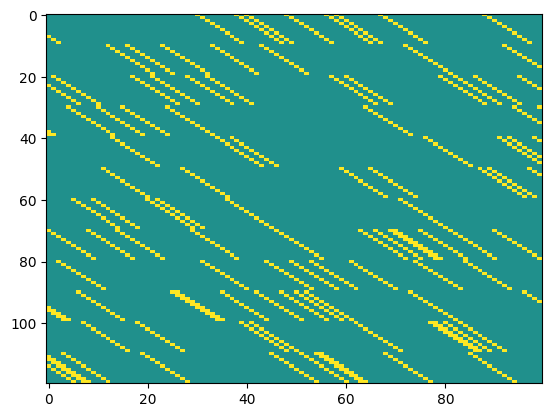

In [8]:
orient_te = time_embed(orient_oh)
orient_te = orient_te.reshape([len(orient_oh), -1])[:10000]
print(orient_te.shape)
imagesc(orient_te[:100].detach().numpy())

In [9]:
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas0 = ((orient_te.T @ Reff).squeeze() / nspks).reshape([len(orient_oh[1]),data.num_lags,-1]).numpy()

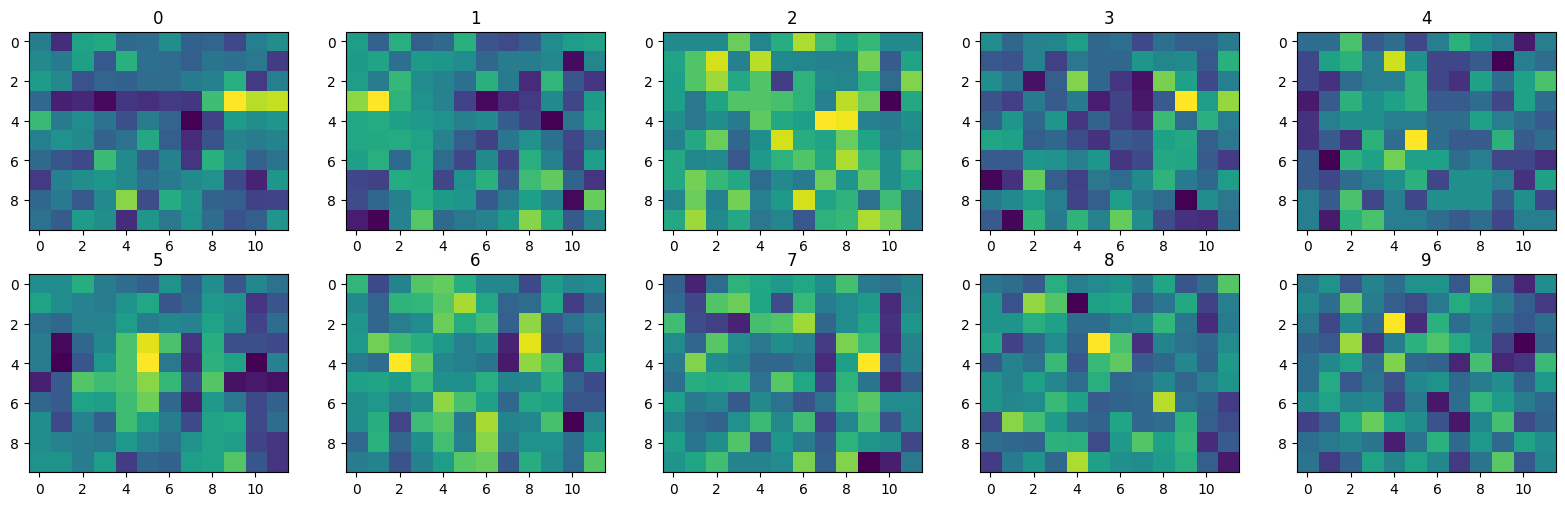

In [10]:
NC = 10
nrows = int(np.ceil(NC/5))
ss(nrows,5)
for cc in range(NC):
    plt.subplot(nrows,5, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

In [11]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=16000,
    max_epochs=3,
    max_iter = 200)

In [12]:
XTreg = 1.0
L1reg = 0.0001

glm_layer = NDNLayer.layer_dict(
    input_dims=data.meta_dims,
    num_filters=1,
    bias=False,
    NLtype='lin',
    initialize_center=True)

glm_layer['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg} 
data.add_covariate('meta_orient', orient_te)
stim_net =  FFnetwork.ffnet_dict( xstim_n='meta_orient', layer_list=[glm_layer] )

In [13]:
torch.cuda.empty_cache()
glm_iter = NDN.NDN(  
    ffnet_list = [stim_net],
    loss_type='poisson')
glm_iter.fit(data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
LLi = glm_iter.eval_models(data[data.val_inds], null_adjusted=False)[0]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8080x120 and 40x1)

In [ ]:
print(LLi)

nan
